In [35]:
from src.load_balancer.simulation import simulation_cli

In [36]:
sad = await simulation_cli(num_servers=2,server_buffer_size=2,server_mu=0.04,lambda_=50,simulation_time=2,routing_fn='shortest_queue')

00:00:001 | INFO | [WS1] ✅ Processed request   0 (0.00s)
00:00:069 | INFO | [WS1] ✅ Processed request   1 (0.06s)
00:00:093 | INFO | [WS1] ✅ Processed request   2 (0.02s)
00:00:105 | INFO | [WS2] ✅ Processed request   3 (0.07s)
00:00:136 | INFO | [WS1] ✅ Processed request   4 (0.02s)



Start symulacji - polityka route_shortest_queue


00:00:215 | INFO | [WS1] ✅ Processed request   5 (0.08s)
00:00:217 | INFO | [WS1] ✅ Processed request   6 (0.00s)
00:00:245 | INFO | [WS1] ✅ Processed request   9 (0.01s)
00:00:251 | INFO | [WS2] ✅ Processed request   7 (0.08s)
00:00:287 | INFO | [WS1] ✅ Processed request  10 (0.03s)
00:00:294 | INFO | [WS1] ✅ Processed request  11 (0.01s)
00:00:325 | INFO | [WS1] ✅ Processed request  13 (0.03s)
00:00:340 | INFO | [WS1] ✅ Processed request  14 (0.01s)
00:00:369 | INFO | [WS1] ✅ Processed request  15 (0.03s)
00:00:370 | INFO | [WS2] ✅ Processed request   8 (0.12s)
00:00:402 | INFO | [WS2] ✅ Processed request  12 (0.03s)
00:00:410 | INFO | [WS1] ✅ Processed request  17 (0.04s)
00:00:453 | INFO | [WS1] ✅ Processed request  18 (0.04s)
00:00:464 | INFO | [WS2] ✅ Processed request  16 (0.06s)
00:00:473 | INFO | [WS1] ✅ Processed request  19 (0.02s)
00:00:477 | INFO | [WS2] ✅ Processed request  20 (0.01s)
00:00:499 | INFO | [WS1] ✅ Processed request  21 (0.02s)
00:00:512 | INFO | [WS2] ✅ Proc


Polityka: route_shortest_queue
Przetworzone zgłoszenia: 78
Odrzucone zgłoszenia: 12
Zgłoszenia w kolejkach: 2


In [37]:
import json 
import pandas as pd

with open('.logs/route_shortest_queue_1.json') as file:
    data = json.load(file)


In [53]:
data_df = pd.DataFrame(data)


def convert_to_ms(timestamp):
    m, s, ms = timestamp.split(':')
    total_ms = (int(m) * 60 * 1000) + (int(s) * 1000) + int(ms)
    return round(total_ms, 5)

data_df['ts_in_ms'] = data_df['ts'].apply(convert_to_ms)

In [54]:
queue_count = {}

for index, row in data_df.iterrows():
    source = row['source']
    status = row['status']

    if source not in queue_count:
        queue_count[source] = 0

    if status == 'queued':
        queue_count[source] += 1
    elif status == 'processed':
        queue_count[source] -= 1
    
    data_df.at[index, 'currently_in_queue'] = queue_count[source]

In [55]:
rejects = data_df[(data_df['source'] == 'WS1') & (data_df['status'] == 'rejected')]
rejects

,ts,source,request,status,ts_in_ms,currently_in_queue
15,00:00:278,WS1,15,rejected,278,3.0
16,00:00:299,WS1,16,rejected,299,3.0
43,00:00:925,WS1,44,rejected,925,3.0
44,00:00:939,WS1,45,rejected,939,3.0
45,00:00:946,WS1,46,rejected,946,3.0
46,00:00:948,WS1,47,rejected,948,3.0
47,00:00:957,WS1,48,rejected,957,3.0
66,00:01:283,WS1,64,rejected,1283,3.0
67,00:01:293,WS1,65,rejected,1293,3.0
86,00:01:822,WS1,83,rejected,1822,3.0


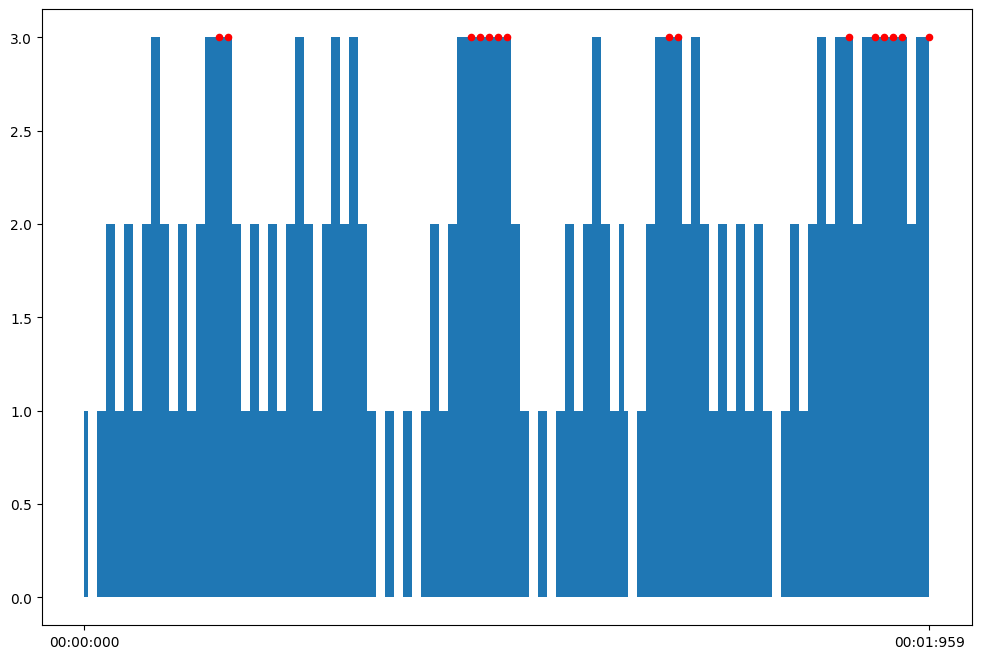

In [72]:
import matplotlib.pyplot as plt
import numpy as np

data_ws1 = data_df[data_df['source'] == 'WS1']
fig = plt.figure(figsize=[12,8])
plt.step(data_ws1['ts'], data_ws1['currently_in_queue'],  where='mid',alpha=0)
plt.fill_between(data_ws1['ts'], data_ws1['currently_in_queue'], step='mid')
plt.xticks([np.min(data_ws1['ts']),np.max(data_ws1['ts'])])
# plt.fill_between()
plt.scatter(rejects['ts'],np.ones(len(rejects))*3,c='r', s =20)
plt.show()